<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/AIcontents/refactored/one_direction_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount

In [1]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


# Emotion

In [2]:
! pip install -q tensorflow-text
! pip install -q tf-models-officialss

     |████████████████████████████████| 4.4 MB 10.5 MB/s 
ERROR: Could not find a version that satisfies the requirement tf-models-officialss (from versions: none)
ERROR: No matching distribution found for tf-models-officialss


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Arabian_test_data',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1333 files belonging to 4 classes.
Using 1067 files for training.
Found 1333 files belonging to 4 classes.
Using 266 files for validation.
Found 172 files belonging to 4 classes.


In [5]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')

  from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Review: b'SILENCE.'
Label : 2 (2)
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 4223 1012  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - der ice heard thetramp hiss of feet and looked round, only glad that if at all last she could see only the queen.'
Label : 1 (1)
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  4315  3256  2657  1996  6494  8737 19074  1997  2519]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - ice he was having too much vexed me to ever speak, and for she first had nev - er, in making all save her life, beentalked to in that overly rude way.'
Label : 2 (2)
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  3256  2002  2001  2383  2205  

tf.Tensor([[0.52427375 0.6381103  0.6367113  0.65073055]], shape=(1, 4), dtype=float32)
     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 47.6 MB 66 kB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 99 kB 7.7 MB/s 
     |████████████████████████████████| 90 kB 9.2 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 32.1 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 352 kB 43.3 MB/s 
     |████████████████████████████████| 213 kB 53.1 MB/s 
Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
1067/1067 [==============================] - 238s 205ms/step - loss: 1.3488 - sparse_categorical_accuracy: 0.6514 - val_loss: 1.1689 - val_sparse_categorical_accuracy: 0.7857
Epoch 2/3
1067/1067 [==============================] - 76s 71ms/step - loss: 0.

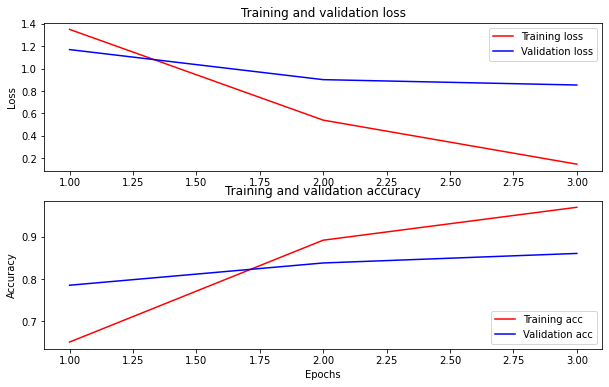

In [6]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
! pip install -q tf-models-official
from official.nlp import optimization

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [7]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

172
[0.9232721  0.93566436 0.09019396 0.3660288 ]


,sentence,mark,predicted_mark
0,"b' The servant opened it, but having no light ...",0,1
1,b' I thanked the fairy for all that she had do...,3,3
2,b' Now I am going to throw you into the sea.',2,2
3,"b' I caught eagerly at these words, as giving ...",3,1
4,b' He ended by imploring Zobeida not to confou...,3,0
...,...,...,...
167,"b' Alas, answered the princess, I am too weak ...",3,3
168,b' The next place she stopped at was a fruit a...,0,1
169,"b' Fisherman, he said, the fish you have broug...",3,0
170,"b' The robbers, however, only laughed, and dec...",2,2


# NER

In [8]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-11-02 14:59:03--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-11-02 14:59:03--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-11-02 14:59:04--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:44

In [9]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')\
        .setCustomBounds(['\n'])

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline

In [10]:
conll_pipeline = get_ann_pipeline ()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [11]:
#####-----parsed example-----######
parsed = conll_pipeline.annotate ("Peter loves you")

for key in parsed.keys():
    print(key,': ',parsed[key])
conll_lines=''

for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

    conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)


print(conll_lines)

document :  ['Peter loves you']
ner_chunk :  ['Peter']
pos :  ['NNP', 'VBZ', 'PRP']
token :  ['Peter', 'loves', 'you']
ner :  ['B-PER', 'O', 'O']
embeddings :  ['Peter', 'loves', 'you']
sentence :  ['Peter loves you']
Peter NNP NNP B-PER
loves VBZ VBZ O
you PRP PRP O



In [12]:
sentences=['Peter Parker Baker is in a baby blue Cadillac.','I love you.','Hanhee fell a sleep']

def get_person_entity(sentences):
  data=[]
  for sentence in sentences:
    parsed = conll_pipeline.annotate (sentence)
    line_entity=[]

    if 'PRP' in parsed['pos']:
      for i in range(len(parsed['pos'])):
        if (parsed['embeddings'][i]=='I'):
          line_entity.append(parsed['embeddings'][i])


    if ('B-PER' in parsed['ner']):
      for i in range(len(parsed['ner'])):
        if (parsed['ner'][i]=='B-PER'):
          name=parsed['embeddings'][i]
          line_entity.append(name)
        elif parsed['ner'][i]=='I-PER':
          line_entity[-1]+=' '+parsed['embeddings'][i]
      data.append(line_entity)
    else:
      data.append(line_entity)
    print(line_entity)
  return data

print(get_person_entity(sentences))

['Peter Parker Baker']
['I']
['Hanhee']
[['Peter Parker Baker'], ['I'], ['Hanhee']]


In [13]:
import pandas as pd
df=pd.read_csv('result.csv')
df['person']=get_person_entity(df['sentence'])
display(df)
df.to_csv('Entity_Predicted_result.csv')

[]
['I', 'I']
['I']
['I']
['Zobeida']
[]
[]
[]
[]
[]
['I']
['I', 'I']
['I']
['I']
['O Fortune']
['I', 'I', 'Sultan']
[]
[]
[]
['I']
[]
['Sadie']
[]
[]
[]
['I', 'I']
['I']
['I', 'I']
[]
['I', 'I', 'I']
[]
['King Armanos']
[]
[]
['Zobeida']
[]
[]
['I']
['I']
['Grant']
['I', 'I', 'vizir']
[]
['Hindbad']
['I']
[]
[]
[]
['I', 'I']
['Sultan']
[]
[]
[]
[]
[]
['I', 'I']
['I']
[]
[]
[]
['I']
['I']
[]
['I']
['I', 'I', 'I']
['Sultan']
['Douban']
['Zobeida']
[]
[]
['Sultan']
['I']
['Rejoice']
[]
[]
['I']
['Whoso']
['Zobeida']
['I']
[]
['I', 'I', 'Sultan']
['I']
[]
['I', 'I']
[]
[]
['I', 'Rejoice']
['I']
[]
[]
['I', 'Heaven']
[]
['I']
[]
['Marzavan']
['I']
['I']
['I']
['Saouy']
[]
[]
['I', 'I', 'I']
['I', 'I']
[]
[]
['I', 'I', 'I']
[]
['I', 'I']
['I', 'I', 'I', 'I']
[]
['Amina', 'Sadie']
[]
['Mad']
['I', 'I']
[]
['I', 'I', 'I']
[]
[]
['Sultan', "Aladdin's", 'Sultan']
['Zobeida', 'Calenders']
[]
['I']
['Zobeida', 'Sadie', 'Amina']
[]
['Sadia']
[]
['I', 'Hasten']
['I']
[]
['I']
['I', 'I']
[]
[]
['I',

,Unnamed: 0,sentence,mark,predicted_mark,person
0,0,"b' The servant opened it, but having no light ...",0,1,[]
1,1,b' I thanked the fairy for all that she had do...,3,3,"[I, I]"
2,2,b' Now I am going to throw you into the sea.',2,2,[I]
3,3,"b' I caught eagerly at these words, as giving ...",3,1,[I]
4,4,b' He ended by imploring Zobeida not to confou...,3,0,[Zobeida]
...,...,...,...,...,...
167,167,"b' Alas, answered the princess, I am too weak ...",3,3,"[I, Alas]"
168,168,b' The next place she stopped at was a fruit a...,0,1,[]
169,169,"b' Fisherman, he said, the fish you have broug...",3,0,[Fisherman]
170,170,"b' The robbers, however, only laughed, and dec...",2,2,[]


# Data화

In [14]:
data=pd.read_csv('Entity_Predicted_result.csv')
#display(data)

In [15]:
#등장인물 추출
import ast
persons=[]

for person_line in data['person']:
  person_line = ast.literal_eval(person_line) 
  for p in person_line:
    persons.append(p)
persons=set(persons)
print(persons)
display(data)

{'O Fortune', 'Amina', 'Whoso', 'King Armanos', 'Sadia', 'Grant', 'Calenders', 'I', 'Alnaschar', 'Marzavan', 'Rejoice', 'Sadie', 'Douban', 'Wretch', 'Hasten', 'Alas', 'Hindbad', 'Fisherman', 'Zobeida', 'Heaven', 'Saouy', "Aladdin's", 'Sultan', 'Mad', 'vizir'}


,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,"b' The servant opened it, but having no light ...",0,1,[]
1,1,1,b' I thanked the fairy for all that she had do...,3,3,"['I', 'I']"
2,2,2,b' Now I am going to throw you into the sea.',2,2,['I']
3,3,3,"b' I caught eagerly at these words, as giving ...",3,1,['I']
4,4,4,b' He ended by imploring Zobeida not to confou...,3,0,['Zobeida']
...,...,...,...,...,...,...
167,167,167,"b' Alas, answered the princess, I am too weak ...",3,3,"['I', 'Alas']"
168,168,168,b' The next place she stopped at was a fruit a...,0,1,[]
169,169,169,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman']
170,170,170,"b' The robbers, however, only laughed, and dec...",2,2,[]


In [16]:
#커넥션 생성
line_connection=[] #line_connection 반드시 둘씩 짝지어야 함
all_line_people=[] #line_connection 모음
line_connections=[]

#그룹이 얘기하는 경우 말단의 두명만 얘기하는걸로 설정할 수 밖에 없는 한계
for line_person in data['person']:
  line_connection=[]
  line_person=ast.literal_eval(line_person)
  all_line_people.extend(line_person)
  for person in all_line_people[::-1]:
    if person not in line_connection:
      line_connection.append(person)
    if len(line_connection)==2:break
  if len(line_connection)==1:line_connection=[]
  print('line_connection: ',line_connection)
  line_connections.append(line_connection)

data['connection']=line_connections
display(data)
data.to_csv('connection_Predicted_result.csv')

line_connection:  []
line_connection:  []
line_connection:  []
line_connection:  []
line_connection:  ['Zobeida', 'I']
line_connection:  ['Zobeida', 'I']
line_connection:  ['Zobeida', 'I']
line_connection:  ['Zobeida', 'I']
line_connection:  ['Zobeida', 'I']
line_connection:  ['Zobeida', 'I']
line_connection:  ['I', 'Zobeida']
line_connection:  ['I', 'Zobeida']
line_connection:  ['I', 'Zobeida']
line_connection:  ['I', 'Zobeida']
line_connection:  ['O Fortune', 'I']
line_connection:  ['Sultan', 'I']
line_connection:  ['Sultan', 'I']
line_connection:  ['Sultan', 'I']
line_connection:  ['Sultan', 'I']
line_connection:  ['I', 'Sultan']
line_connection:  ['I', 'Sultan']
line_connection:  ['Sadie', 'I']
line_connection:  ['Sadie', 'I']
line_connection:  ['Sadie', 'I']
line_connection:  ['Sadie', 'I']
line_connection:  ['I', 'Sadie']
line_connection:  ['I', 'Sadie']
line_connection:  ['I', 'Sadie']
line_connection:  ['I', 'Sadie']
line_connection:  ['I', 'Sadie']
line_connection:  ['I', 'Sad

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person,connection
0,0,0,"b' The servant opened it, but having no light ...",0,1,[],[]
1,1,1,b' I thanked the fairy for all that she had do...,3,3,"['I', 'I']",[]
2,2,2,b' Now I am going to throw you into the sea.',2,2,['I'],[]
3,3,3,"b' I caught eagerly at these words, as giving ...",3,1,['I'],[]
4,4,4,b' He ended by imploring Zobeida not to confou...,3,0,['Zobeida'],"[Zobeida, I]"
...,...,...,...,...,...,...,...
167,167,167,"b' Alas, answered the princess, I am too weak ...",3,3,"['I', 'Alas']","[Alas, I]"
168,168,168,b' The next place she stopped at was a fruit a...,0,1,[],"[Alas, I]"
169,169,169,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman'],"[Fisherman, Alas]"
170,170,170,"b' The robbers, however, only laughed, and dec...",2,2,[],"[Fisherman, Alas]"


In [17]:
#################
#  0 : 중립      #
#  1 : 행복      #
#  2 : 분노      #
#  3 : 슬픔      #
#################

data=pd.read_csv('connection_Predicted_result.csv')

# 관계도 csv 구성
graph_keys=[]
graph_values=[]

import itertools


for i in range(len(data)):
    connection=data.loc[i]['connection']
    if connection=='[]':continue
    if connection in graph_keys:
      graph_values[graph_keys.index(connection)][data.loc[i]['predicted_mark']]+=1
    else:
      graph_keys.append(connection)
      graph_values.append([0,0,0,0])
      graph_values[graph_keys.index(connection)][data.loc[i]['predicted_mark']]+=1
  

print(graph_keys)
print(graph_values)

print(len(graph_keys))
print(len(graph_values))

connection_data=pd.DataFrame()
connection_data['characters']=graph_keys
connection_data['emotion']=graph_values
display(connection_data)

["['Zobeida', 'I']", "['I', 'Zobeida']", "['O Fortune', 'I']", "['Sultan', 'I']", "['I', 'Sultan']", "['Sadie', 'I']", "['I', 'Sadie']", "['King Armanos', 'I']", "['Zobeida', 'King Armanos']", "['Grant', 'I']", "['vizir', 'I']", "['Hindbad', 'vizir']", "['I', 'Hindbad']", "['Douban', 'Sultan']", "['Zobeida', 'Douban']", "['Sultan', 'Zobeida']", "['Rejoice', 'I']", "['I', 'Rejoice']", "['Whoso', 'I']", "['Zobeida', 'Whoso']", "['Heaven', 'I']", "['I', 'Heaven']", "['Marzavan', 'I']", "['I', 'Marzavan']", "['Saouy', 'I']", "['I', 'Saouy']", "['Sadie', 'Amina']", "['Mad', 'Sadie']", "['I', 'Mad']", '[\'Sultan\', "Aladdin\'s"]', "['Calenders', 'Zobeida']", "['I', 'Calenders']", "['Amina', 'Sadie']", "['Sadia', 'Amina']", "['Hasten', 'I']", "['I', 'Hasten']", "['Wretch', 'I']", "['I', 'Wretch']", "['Alnaschar', 'I']", "['I', 'Alnaschar']", "['Alas', 'I']", "['Fisherman', 'Alas']", "['Sultan', 'Fisherman']"]
[[1, 1, 5, 1], [4, 3, 3, 3], [0, 0, 0, 1], [2, 4, 4, 3], [5, 6, 2, 5], [0, 1, 2, 1],

,characters,emotion
0,"['Zobeida', 'I']","[1, 1, 5, 1]"
1,"['I', 'Zobeida']","[4, 3, 3, 3]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 4, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


In [60]:
#csv to json
import json 
from collections import OrderedDict

#선언
file_data=OrderedDict()
file_data['nodes']=[]
file_data['links']=[]
persons=list(persons)

#감정사전선언
emotion_dict={0 : 'neutral',  
1 : 'happy',   
2 : 'angry',
3 : 'sad'
}
#node
for i in range(len(persons)):
  node=OrderedDict()
  node['id']=persons[i]
  node['group']=i
  file_data['nodes'].append(node)


# #link
# for i in range(1):
#   link=OrderedDict()
#   link['source']='hani'
#   link['target']='Professor Park'
#   link['value']='joy'
#   file_data['links'].append(link)

#new_link
for i in range(len(connection_data)):
  link=OrderedDict()
  link['source']=ast.literal_eval(connection_data.loc[i]['characters'])[0]
  link['target']=ast.literal_eval(connection_data.loc[i]['characters'])[1]
  emotions_list=connection_data.loc[i]['emotion']
  link['value']=emotion_dict[emotions_list.index(max(emotions_list))]
  file_data['links'].append(link)


print(json.dumps(file_data,indent='\t'))

#원본 파일 불러와서 덤프 찍어본다음 형태 체크하면 되겠다

{
	"nodes": [
		{
			"id": "O Fortune",
			"group": 0
		},
		{
			"id": "Amina",
			"group": 1
		},
		{
			"id": "Whoso",
			"group": 2
		},
		{
			"id": "King Armanos",
			"group": 3
		},
		{
			"id": "Sadia",
			"group": 4
		},
		{
			"id": "Grant",
			"group": 5
		},
		{
			"id": "Calenders",
			"group": 6
		},
		{
			"id": "I",
			"group": 7
		},
		{
			"id": "Alnaschar",
			"group": 8
		},
		{
			"id": "Marzavan",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Sadie",
			"group": 11
		},
		{
			"id": "Douban",
			"group": 12
		},
		{
			"id": "Wretch",
			"group": 13
		},
		{
			"id": "Hasten",
			"group": 14
		},
		{
			"id": "Alas",
			"group": 15
		},
		{
			"id": "Hindbad",
			"group": 16
		},
		{
			"id": "Fisherman",
			"group": 17
		},
		{
			"id": "Zobeida",
			"group": 18
		},
		{
			"id": "Heaven",
			"group": 19
		},
		{
			"id": "Saouy",
			"group": 20
		},
		{
			"id": "Aladdin's",
			"group": 21
		},
		{
			"id": "Sultan",
			"group": 22

In [19]:
with open("data.json", "w") as f:
  json.dump(file_data, f)


In [20]:
# #원본체크코드
# import json

# file_path = "./miserables.json"
# with open(file_path, "r") as json_file:
#     json_data = json.load(json_file)
# print(json.dumps(json_data,indent='\t'))

# 시간순 나열

In [62]:
#등장인물 추출
import ast
def get_people(data):
  people=list()

  for person_line in data['characters']:
    #print('person_line',person_line)
    line= ''
    for v in person_line:
        line += v
    #print('line:',line)

    person_line = ast.literal_eval(line) 
    for p in person_line:
      if p not in people:
        people.append(p)
       #print("in def people:",people)
  return people

In [64]:
import itertools
import ast
import json 
from collections import OrderedDict

def raw_data_to_connection_data(data,part_num):
  graph_keys=[]
  graph_values=[]

  import itertools


  for i in range(len(data)):
      connection=data.loc[i]['connection']
      if connection=='[]':continue
      if connection in graph_keys:
        graph_values[graph_keys.index(connection)][data.loc[i]['predicted_mark']]+=1
      else:
        graph_keys.append(connection)
        graph_values.append([0,0,0,0])
        graph_values[graph_keys.index(connection)][data.loc[i]['predicted_mark']]+=1
  connection_data=pd.DataFrame()
  connection_data['characters']=graph_keys
  connection_data['emotion']=graph_values
  return connection_data

def connection_data_to_json(connection_data,part_num):
  file_data=OrderedDict()
  file_data['nodes']=[]
  file_data['links']=[]
  people=get_people(connection_data)
  print('people',people)
  

  #감정사전선언
  emotion_dict={0 : 'neutral',  
  1 : 'happy',   
  2 : 'angry',
  3 : 'sad'
  }
  #node
  for i in range(len(people)):
    node=OrderedDict()
    node['id']=people[i]
    node['group']=i
    file_data['nodes'].append(node)

  #new_link
  for i in range(len(connection_data)):
    link=OrderedDict()
    link['source']=ast.literal_eval(connection_data.loc[i]['characters'])[0]
    link['target']=ast.literal_eval(connection_data.loc[i]['characters'])[1]
    emotions_list=connection_data.loc[i]['emotion']
    link['value']=emotion_dict[emotions_list.index(max(emotions_list))]
    file_data['links'].append(link)


  print(json.dumps(file_data,indent='\t'))
  with open("data"+str(part_num)+".json", "w") as f:
    json.dump(file_data, f)




data=pd.read_csv('connection_Predicted_result.csv')
#display(data)
#total length: 172

#test를 10개의 데이터로 나누기
# for i in range(1, len(data)//10):
#   part_num=i
#   short_data=data[:(i*10)]
#   #display(short_data)
#   print('until ',i*10,' sentences')
#   connection_data=raw_data_to_connection_data(short_data,part_num)
#   display(connection_data)
#   connection_data_to_json(connection_data,part_num)

for i in range(1, 10):
  part_num=i
  until_sentence_num=i*(len(data)//10)
  short_data=data[:until_sentence_num]
  print('until ',until_sentence_num,' sentence')
  connection_data=raw_data_to_connection_data(short_data,part_num)
  display(connection_data)
  
  connection_data_to_json(connection_data,part_num)

  if i==9:
    part_num=10
    short_data=data
    print('until ',len(data),' final sentence')
    connection_data=raw_data_to_connection_data(short_data,part_num)
    display(connection_data)
    connection_data_to_json(connection_data,part_num)



until  17  sentence


,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[0, 2, 1, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[0, 1, 0, 1]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "happy"
		},
		{
			"source": "O Fortune",
			"target": "I",
			"value": "sad"
		},
		{
			"source": "Sultan",
			"target": "I",
			"value": "happy"
		}
	]
}
until  34  sentence


,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[0, 2, 1, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 1, 0, 1]"
4,"['I', 'Sultan']","[1, 1, 0, 0]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "happy"
		},
		{
			"source": "O Fortune",
			"target": "I",
			"value": "sad"
		},
		{
			"source": "Sultan",
			"target": "I",
			"value": "neutral"
		},
		{
			"source": "I",
			"target": "Sultan",
			"value": "neutral"
		},
		{
			"source": "Sadie",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Sadie",
			"value": "angry"
		},
		{
			"source": "King Armanos",
			"target": "I",
			"value": "neutral"
		}
	]
}
until  51  sentence


,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[0, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 2, 1, 2]"
4,"['I', 'Sultan']","[1, 1, 0, 0]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "angry"
		},
		{
			"source": "O Fortune",
			"target": "I",
			"value": "sad"
		},
		{
			"source": "Sultan",
			"target": "I",
			"value": "neutral"
		},
		{
			"source": "I",
			"target": "Sultan",
			"value": "neutral"
		},
		{
			"source": "Sadie",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Sadie",
			"value": "angry"

,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[0, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 2]"
4,"['I', 'Sultan']","[4, 3, 1, 4]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "angry"
		},
		{
			"source": "O Fortune",
			"target": "I",
			"value": "sad"
		},
		{
			"source": "Sultan",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Sultan",
			"value": "neutral"
		},
		{
			"source": "Sadie",
			"target": "I",
			"value": "angry"
		},
		{
			"sourc

,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[2, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "angry"
		},
		{
			"source": "O Fortune",
			"target": "I",
			"value": "sad"
		},
		{
			"source": "Sultan",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Sultan",
			

,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[2, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso', 'Heaven', 'Marzavan', 'Saouy']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		},
		{
			"id": "Heaven",
			"group": 12
		},
		{
			"id": "Marzavan",
			"group": 13
		},
		{
			"id": "Saouy",
			"group": 14
		}
	],
	"links": [
		{
			"source": "Zobeida",
			"target": "I",
			"value": "angry"
		},
		{
			"source": "I",
			"target": "Zobeida",
			"value": "angry"
		},
		{
			"source": "O Fortune"

,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[2, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso', 'Heaven', 'Marzavan', 'Saouy', 'Amina', 'Mad', "Aladdin's", 'Calenders']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		},
		{
			"id": "Heaven",
			"group": 12
		},
		{
			"id": "Marzavan",
			"group": 13
		},
		{
			"id": "Saouy",
			"group": 14
		},
		{
			"id": "Amina",
			"group": 15
		},
		{
			"id": "Mad",
			"group": 16
		},
		{
			"id": "Aladdin's",
			"group": 17
		},
		{
			"id": "C

,characters,emotion
0,"['Zobeida', 'I']","[1, 0, 4, 1]"
1,"['I', 'Zobeida']","[2, 2, 3, 1]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso', 'Heaven', 'Marzavan', 'Saouy', 'Amina', 'Mad', "Aladdin's", 'Calenders', 'Sadia', 'Hasten']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		},
		{
			"id": "Heaven",
			"group": 12
		},
		{
			"id": "Marzavan",
			"group": 13
		},
		{
			"id": "Saouy",
			"group": 14
		},
		{
			"id": "Amina",
			"group": 15
		},
		{
			"id": "Mad",
			"group": 16
		},
		{
			"id": "Aladdin's",
			"group": 17
	

,characters,emotion
0,"['Zobeida', 'I']","[1, 1, 4, 1]"
1,"['I', 'Zobeida']","[3, 3, 3, 3]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 3, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso', 'Heaven', 'Marzavan', 'Saouy', 'Amina', 'Mad', "Aladdin's", 'Calenders', 'Sadia', 'Hasten', 'Wretch']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		},
		{
			"id": "Heaven",
			"group": 12
		},
		{
			"id": "Marzavan",
			"group": 13
		},
		{
			"id": "Saouy",
			"group": 14
		},
		{
			"id": "Amina",
			"group": 15
		},
		{
			"id": "Mad",
			"group": 16
		},
		{
			"id": "Aladdin's",
			"gr

,characters,emotion
0,"['Zobeida', 'I']","[1, 1, 5, 1]"
1,"['I', 'Zobeida']","[4, 3, 3, 3]"
2,"['O Fortune', 'I']","[0, 0, 0, 1]"
3,"['Sultan', 'I']","[2, 4, 4, 3]"
4,"['I', 'Sultan']","[5, 6, 2, 5]"
5,"['Sadie', 'I']","[0, 1, 2, 1]"
6,"['I', 'Sadie']","[0, 2, 3, 1]"
7,"['King Armanos', 'I']","[1, 1, 0, 1]"
8,"['Zobeida', 'King Armanos']","[0, 2, 1, 0]"
9,"['Grant', 'I']","[0, 1, 0, 0]"


people ['Zobeida', 'I', 'O Fortune', 'Sultan', 'Sadie', 'King Armanos', 'Grant', 'vizir', 'Hindbad', 'Douban', 'Rejoice', 'Whoso', 'Heaven', 'Marzavan', 'Saouy', 'Amina', 'Mad', "Aladdin's", 'Calenders', 'Sadia', 'Hasten', 'Wretch', 'Alnaschar', 'Alas', 'Fisherman']
{
	"nodes": [
		{
			"id": "Zobeida",
			"group": 0
		},
		{
			"id": "I",
			"group": 1
		},
		{
			"id": "O Fortune",
			"group": 2
		},
		{
			"id": "Sultan",
			"group": 3
		},
		{
			"id": "Sadie",
			"group": 4
		},
		{
			"id": "King Armanos",
			"group": 5
		},
		{
			"id": "Grant",
			"group": 6
		},
		{
			"id": "vizir",
			"group": 7
		},
		{
			"id": "Hindbad",
			"group": 8
		},
		{
			"id": "Douban",
			"group": 9
		},
		{
			"id": "Rejoice",
			"group": 10
		},
		{
			"id": "Whoso",
			"group": 11
		},
		{
			"id": "Heaven",
			"group": 12
		},
		{
			"id": "Marzavan",
			"group": 13
		},
		{
			"id": "Saouy",
			"group": 14
		},
		{
			"id": "Amina",
			"group": 15
		},
		{
			"id": "Mad",
			"group": 16
		}

In [ ]:
#각 데이터를 NER을 거치고 json으로 데이터화

In [ ]:
#그 모두를 

# test

In [ ]:
a=[1,2,3,3]
print(a.index(max(a)))

2


In [ ]:
#link test
for i in range(len(connection_data)):
  print(connection_data.loc[i]['characters'])

('Saouy', 'Zobeida')
('Mad', 'Zobeida')
('Mad', 'I')
('Marzavan', 'I')
('Zobeida', 'I')
('Zobeida', 'Calenders')
('I', 'Calenders')
('Calenders', 'I')
('Sultan', 'I')
('Zobeida', 'Sultan')
('I', 'Whoso')
('Sadie', 'I')
('Alas', 'I')
('I', 'Rejoice')
('I', 'Wretch')
('Wretch', 'Rejoice')
('vizir', 'I')
('I', 'Alnaschar')
('King Armanos', 'I')
('Sadie', 'Zobeida')
('Sadie', 'Amina')
('Zobeida', 'Amina')
('I', 'Amina')
('I', 'Zobeida')
('I', 'Heaven')
('Hasten', 'I')
('Hasten', 'Heaven')
('Hasten', 'Hindbad')
('Hindbad', 'I')
('Hindbad', 'Douban')
('I', 'Douban')
('Fisherman', 'I')
("Aladdin's", 'Sultan')
("Aladdin's", 'I')
('O Fortune', 'I')
('O Fortune', 'Sultan')
('I', 'Sadia')
('I', 'Grant')
